In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


# Load Dataset

In [7]:
sample = pd.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')
train = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')

| Variables | (Eng)Description | (한글)요약
|:------:|---|---|
|**id**| Unique ID for the customer | 고객 ID
|**Gender**| Gender of the customer | 성별
|**Age**| Age of the customer | 나이
|**Driving_License**| 0 : Customer does not have DL, 1 : Customer already has DL | 운전면허 여부(0: 없음, 1: 있음)
|**Region_Code**|Unique code for the region of the customer|지역코드
|**Previously_Insured**|1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance|보험여부(0: 없음, 1: 있음)
|**Vehicle_Age**|Age of the Vehicle|차량 연식
|**Vehicle_Damage**|1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.|손상여부(0:없음, 1:있음)
|**Annual_Premium**|The amount customer needs to pay as premium in the year|연간 보험료
|**Policy_Sales_Channel**|Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.|판매 채널
|**Vintage**|Number of Days, Customer has been associated with the company|가입기간(일)
|**Response**(target)|1 : Customer is interested, 0 : Customer is not interested|고객 반응여부(0: 관심없음, 1: 관심있음)

## Data preview

In [11]:
display(test.shape, test.dtypes, test.head(3), "*********************************************", train.shape, train.dtypes, train.head(3))

(7669866, 11)

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
dtype: object

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271


'*********************************************'

(11504798, 12)

id                        int32
Gender                   object
Age                        int8
Driving_License            int8
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0


In [12]:
def resumetable(df):
  print(f'shape: {df.shape}')
  summary = pd.DataFrame(df.dtypes, columns = ['Data type']).reset_index()
  summary = summary.rename(columns={'index': 'Feature'})
  summary['MissingValues'] = df.isnull().sum().values
  summary['NUnique'] = df.nunique().values
  summary['row_1'] = df.loc[0].values #1st row
  summary['row_2'] = df.loc[1].values #2nd row
  summary['row_-2'] = df.iloc[-2].values #2nd row from the back
  summary['row_-1'] = df.iloc[-1].values #last row

  return summary

In [13]:
resumetable(train)

shape: (11504798, 12)


,Feature,Data type,MissingValues,NUnique,row_1,row_2,row_-2,row_-1
0,id,int32,0,11504798,0,1,11504796,11504797
1,Gender,object,0,2,Male,Male,Female,Male
2,Age,int8,0,66,21,43,51,25
3,Driving_License,int8,0,2,1,1,1,1
4,Region_Code,float64,0,54,35.0,28.0,28.0,28.0
5,Previously_Insured,int64,0,2,0,0,0,1
6,Vehicle_Age,object,0,3,1-2 Year,> 2 Years,1-2 Year,< 1 Year
7,Vehicle_Damage,object,0,2,Yes,Yes,Yes,No
8,Annual_Premium,float64,0,51728,65101.0,58911.0,48443.0,32855.0
9,Policy_Sales_Channel,float64,0,152,124.0,26.0,26.0,152.0


## Downcasting

> **We need a memory optimization by downcasting**

In [ ]:
def downcasting(df, verbose=True):
  """
  데이터프레임의 메모리 사용량을 줄이기 위해 데이터 타입을 다운캐스팅
  Args:
    df: 다운캐스팅할 pandas DataFrame
    verbose: True이면 다운캐스팅 진행 상황을 출력 (기본값: True)

  Returns:
    다운캐스팅된 pandas DataFrame
  """
  start_mem = df.memory_usage().sum()/ 1024**2  # 데이터프레임의 초기 메모리 사용량을 MB 단위로 계산
  for col in df.columns:
    dtype_name = df[col].dtype.name
    if dtype_name == 'object':  # 데이터 타입이 'object'인 경우
      pass  # 아무 작업도 하지 않고 넘어갑니다. (다운캐스팅 불가)
    elif dtype_name == 'bool':  # 데이터 타입이 'bool'인 경우
      df[col] = df[col].astype('int8')  # 'int8' 타입으로 변환합니다. (True -> 1, False -> 0)
    elif dtype_name.startswith('int') or (df[col].round()==df[col]).all(): 
      # 데이터 타입이 'int'로 시작하거나, 열의 모든 값이 정수인 경우
      # (예: 1.0, 2.0과 같이 소수점 이하가 0인 경우)
      df[col] = pd.to_numeric(df[col], downcast='integer')
      # 'integer'로 다운캐스팅 가능한 가장 작은 정수 타입으로 변환합니다.
      # (예: int64 -> int32, int16, int8 순서로)
    else:  # 그 외의 경우 (float 등)
      df[col] = pd.to_numeric(df[col], downcast='float') 
      # 'float'로 다운캐스팅 가능한 가장 작은 실수 타입으로 변환합니다.
      # (예: float64 -> float32)
  end_mem = df.memory_usage().sum()/1024**2  # 데이터프레임의 최종 메모리 사용량을 MB 단위로 계산합니다.
  if verbose:  # verbose가 True인 경우
    print('{:.1f}% downcasting'.format(100*(start_mem - end_mem)/start_mem)) 
    # 메모리 사용량 감소율을 출력합니다.
    # (시작 메모리 - 종료 메모리) / 시작 메모리 * 100
  return df  # 다운캐스팅된 데이터프레임을 반환합니다.

downcasting(train)
downcasting(test)

display(train.shape, test.shape)
print(f'Total row: {train.shape[0] + test.shape[0]} rows')

43.6% downcasting
54.5% downcasting


(11504798, 12)

(7669866, 11)

Total row: 19174664 rows


In [ ]:
# 사용하지 않는 메모리 회수
import gc
display(gc.get_threshold(), gc.get_count())
# gc.get_threshold(): garbage collention의 임계값을 튜플 형태로 반환. 0세대 -> 1세대 -> 2세대
# gc.get_count(): 현재 각 세대별 수집 객체 수를 튜플 형태로 반환
# gc.set_debug()

gc.collect()

(700, 10, 10)

(69, 4, 0)

37

# EDA

## check a data distribution

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats
import warnings
warnings.filterwarnings('ignore')

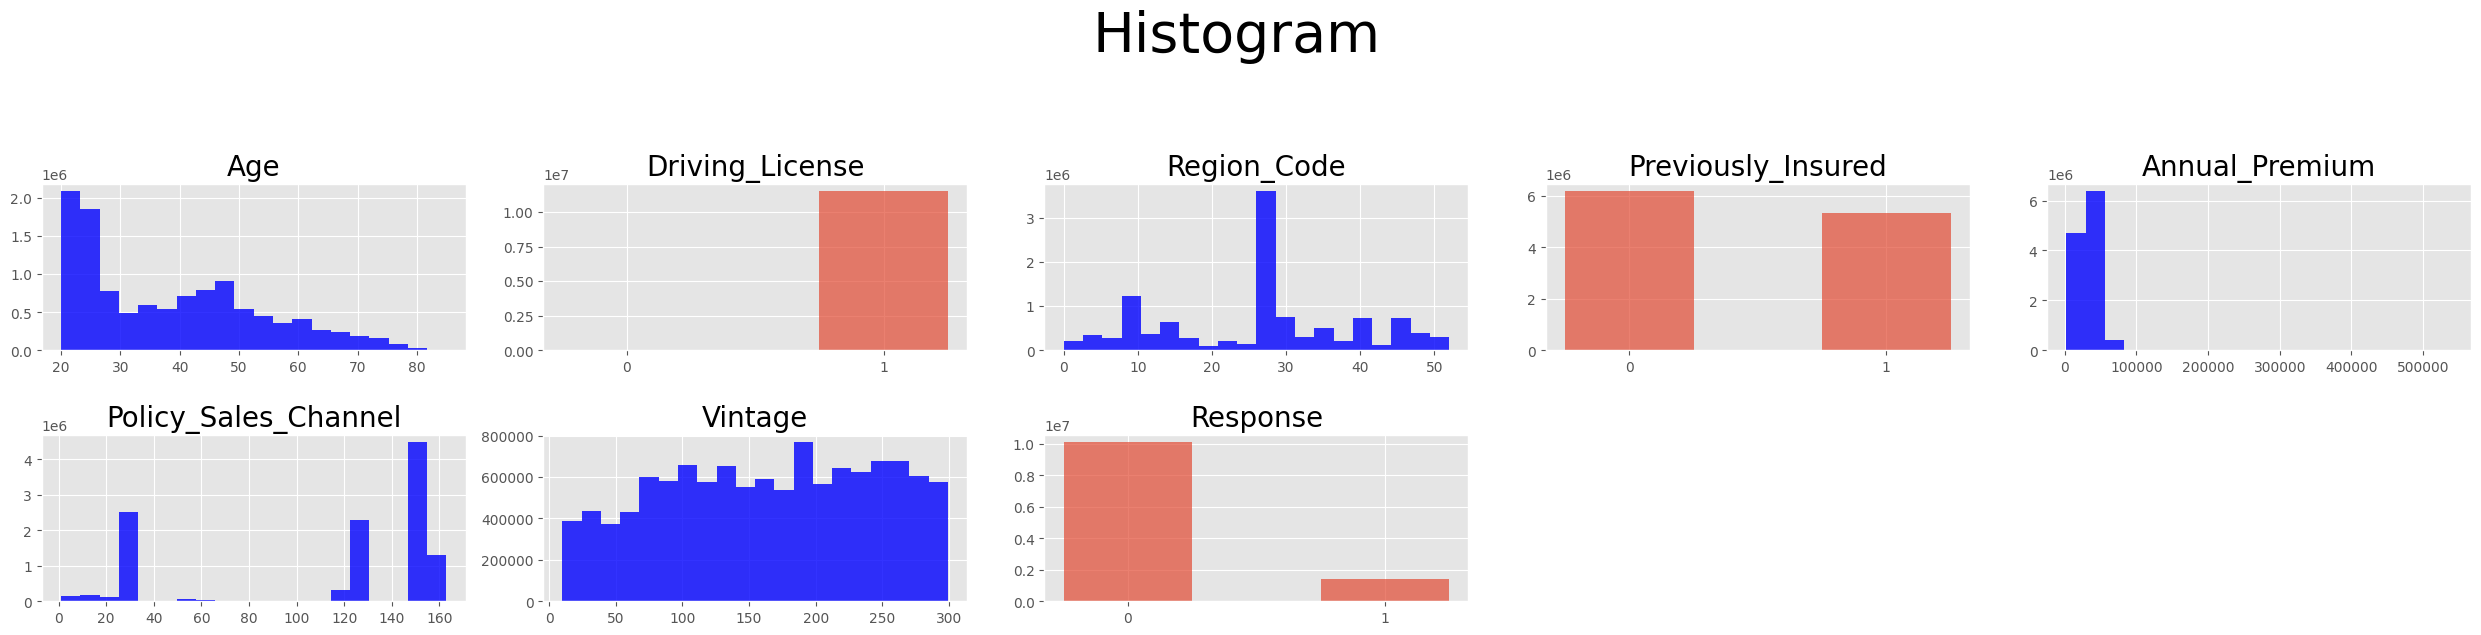

In [ ]:
viz = []
for i in train.columns:
    if train[i].dtypes == 'object':
        pass
    else:
        viz.append(i)

plt.style.use("ggplot")
plt.figure(figsize=(25,20))
plt.suptitle("Histogram", fontsize=40)
        
for i in range(len(viz)-1):
    plt.subplot(5,5,i+1)
    plt.title(viz[i+1], fontsize=20)
    
    if len(train[viz[i+1]].unique())>20:
        plt.hist(train[viz[i+1]], bins=20, color='b', alpha=0.8)
    else:
        temp = train[viz[i+1]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())

plt.tight_layout(rect=[0, 0.3, 1, 0.95]) # 왼쪽, 아래, 오른쪽, 위
plt.show()

- Age, Driving_License, Annual_Premium, Policy_Sales_Channel, Response features are looks imbalaced.

In [21]:
train['Driving_License'].value_counts()

Driving_License
1    11482041
0       22757
Name: count, dtype: int64

In [22]:
train['Annual_Premium'].value_counts()

Annual_Premium
2630     2112561
38287       6363
39008       5285
38452       4721
28861       4671
          ...   
77839          1
67126          1
15999          1
59067          1
64538          1
Name: count, Length: 51728, dtype: int64

In [23]:
box_data = train[viz]
box_data['target'] = train['Response'].values
box_data.drop(columns = ['id', 'Response', 'Driving_License'], axis=1, inplace=True)

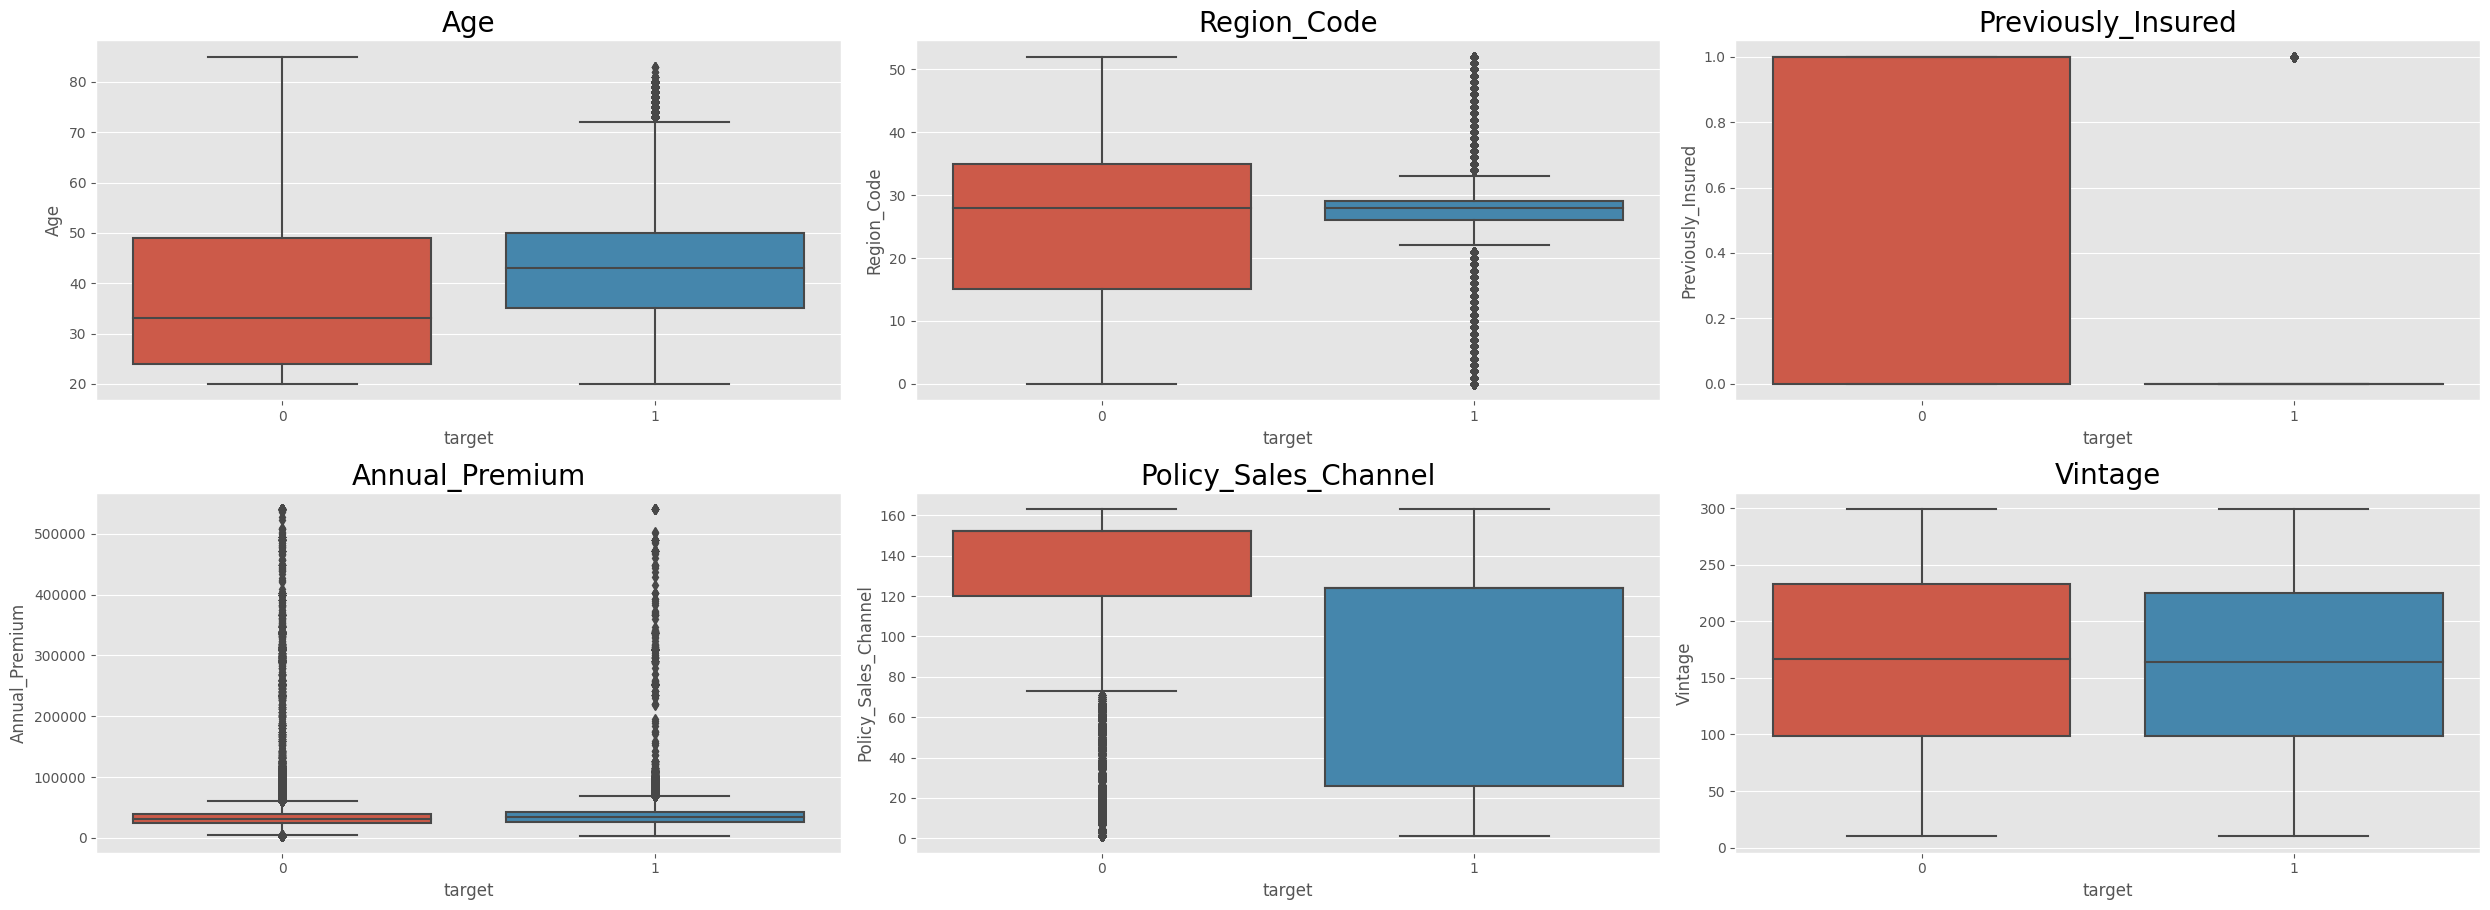

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(25, 10))

for ax, col in zip(axes.flat, box_data.columns[:-1]):
    sns.boxplot(x='target', y=col, ax=ax, data=box_data) #target is 'Response'
    ax.set_title(col, fontsize=20)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [29]:
for i in box_data.columns:
    print(f'Skewness of {i}: {box_data[i].skew()}')

Skewness of Age: 0.63727777028377
Skewness of Region_Code: -0.13077330589294434
Skewness of Previously_Insured: 0.14842075311726782
Skewness of Annual_Premium: 0.7769368302401036
Skewness of Policy_Sales_Channel: -0.91508208339766
Skewness of Vintage: -0.10813312009469143
Skewness of target: 2.2957589163109744


- Skewness = 0: 데이터 분포 완벽 대칭. 평균, 중앙값, 최빈값 모두 동일
- Skewness > 0: Posivive Skew(오른쪽 꼬리 분포). 중앙값<평균(극단 값이 오른쪽에 분포)
- Skenness < 0: Negative Skew(왼쪽 꼬리 분포). 중앙값>평균(극단 값이 왼쪽에 분포)
- 절대값이 클 수록 비대칭 정도가 심하다
- target의 경우 큰 양의 왜도이므로 대부분 0일 가능성이 높음 -> stratified 옵션 사용

- We'll have to check this values(Especially Age, Previously_Insured, Annual_Premium, Policy_Sales_Channel)
> **Since we participated in the competition late, efficient choice was the most important thing.
The skewness is close to zero, so I didn't do any big work.
However, these tasks seem necessary if you participate in the next competition.**

# Feature Engineering

## Concat

In [30]:
all_data = pd.concat([train, test], ignore_index = True)
all_data = all_data.drop(['id', 'Response'], axis = 1) #After processing, drop 'Response' col.
all_data.shape

(19174664, 10)

## Encoding

> **I didn't ohe the whole data. I only did it for categorical features. Because when I train models, it's less efficient in speed(time).**

In [31]:
# - Gender(M/F)
# - VA(<1, 1-2, 2>)
# - VD(Y/N)

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

all_data_en = all_data.copy()

In [ ]:
cat = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

ohe = OneHotEncoder()

# train_en = train_en.apply(lambda x: le.fit_transform(x))
all_data_en_matrix = ohe.fit_transform(all_data_en[cat]) # sparse matrix
all_data_en_matrix

<19174664x7 sparse matrix of type '<class 'numpy.float64'>'
	with 57523992 stored elements in Compressed Sparse Row format>

In [ ]:
# sparse matrix 장점: ohe 적용 -> 0이 많아지므로 메모리 사용량을 줄이기 위해 사용, 바로 모델 학습에 사용 가능
from scipy import sparse

all_data_en = all_data_en.drop(cat, axis=1)
all_data_en_sprs = sparse.hstack([sparse.csr_matrix(all_data_en),
                        all_data_en_matrix],
                        format='csr')
# sparse matrix를 가로로 합하기(hstack)
# all_data_en 데이터프레임을 csr_matrix로 변환하고 ohe 적용한 sparse matrix랑 병합, 포맷은 csr

In [35]:
all_data_en_sprs

<19174664x14 sparse matrix of type '<class 'numpy.float64'>'
	with 181313867 stored elements in Compressed Sparse Row format>

In [36]:
num_train = len(train)

X = all_data_en_sprs[:num_train] #X_train
X_test = all_data_en_sprs[num_train:] #test
y = train['Response'].values #y_train

# Modeling

> **We also used XGB, CATB. It proceeded with the similar process as LGBM.**

> **If you modify the code a little bit, you can proceed with the ensemble as well.
In this notebook, I've only done it for LGBM with Optuna library, and I reveal it.**

In [38]:
pip install optuna-integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 1.9 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import datetime
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.base import clone
from lightgbm import early_stopping # 성능 개선 미미 & 과적합 -> 조기 종료
from lightgbm import log_evaluation # 학습 진행 상황 로그로 기록 -> 디버깅용

#model evaluation
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss, auc, accuracy_score

# Optuna and visualization tools
import optuna
from optuna.trial import Trial
from optuna.integration import LightGBMPruningCallback

from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances

## Optuna

- **.suggest_** : it helps you find to hyperparameters
- **.create study** : https://optuna.readthedocs.io/en/v2.0.0/reference/alias_generated/optuna.create_study.html
- **.optimize** : i recommand you to n_jobs=-1. I'm not sure about the technical part, but this setup will help you with parallelization.

> ref: https://optuna.readthedocs.io/en/stable/index.html 

In [ ]:
def objective(trial):
    params = {
    'boosting_type':'gbdt', 
    # defalut(gbdt), dart: 과적합 방지 효과, goss: 속도에 이점, rf: randomforest
    'n_estimators':trial.suggest_int('n_estimators', 100, 1000, step = 100), # n_estimators: 트리 개수 결정
    'max_bin':trial.suggest_int('max_bin', 1000, 30000), 
    # max_bin: 숫자형 feature 값 구간(bin) 지정, 클 수록 세밀하게 나눌 수 있으나 과적합 위험
    'subsample':trial.suggest_categorical('subsample', [0.8, 0.9, 1.0]), 
    #샘플링 비율 선택, 과적합 방지(너무 작으면 underfitting)
    'subsample_freq':trial.suggest_int('subsample_freq', 1, 8), 
    #subsample_freq: subsample_freq=1이면 매 트리 학습 시 데이터 샘플링 수행, 낮을 수록 과적합 방지
    'colsample_bytree':trial.suggest_categorical('colsample_bytree', [0.3, 0.45, 0.6, 0.75, 0.9]), 
    # 각 트리 학습 시 사용할 feature의 샘플링 비율 결정(0.5 = 전체 feature의 50%만 무작위로 선택해서 트리 학습)
    # 과적합 방지(너무 작으면 underfitting)
    'num_leaves':trial.suggest_int('num_leaves', 2, 300),
    # num_leaves: 각 트리에서 가질 수 있는 최대 리프 노드의 개수 결정(클 수록 복잡하고 과적합 위험)
#     'skip_drop':trial.suggest_float('skip_drop', 0.7, 0.9), # dart 옵션 시 사용. drop할 트리 개수
    'max_depth':-1, # max depth: -1 옵션(트리 깊이 제한 없음), 깊을 수록 모델 복잡하고 과적합 위험
    'learning_rate':0.1, # 작을 수록 과적합
    'n_jobs':-1, # CPU 코어
    'early_stopping_round': 50, # 50라운드 설정
    'random_state':101,
    'verbose':-1, # 로그 출력(>0: 진행 상황 출력, 0: 경고 외 출력 x, -1: 아무 메세지 출력 x)
    }
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, stratify = y, random_state=101)
    # Train the model
    model = LGBMClassifier(**params)
    pruning_callback = LightGBMPruningCallback(trial, "binary_logloss", valid_name="validation_0") # 검증 데이터셋 validation_0
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_names=["validation_0"],
              callbacks=[early_stopping(stopping_rounds=50), pruning_callback], #when use dart, don't use the 'early_stopping'
              eval_metric='auc'
              ) # 50 라운드 동안 성능 개선이 없으면 early stopping

    # Predict probabilities
    y_pred = model.predict_proba(X_val)[:, 1] # X_val에 대한 각 클래스별 예측 확률 계산 -> 클래스 1 확률만 선택

    # Evaluate the model
    auc = roc_auc_score(y_val, y_pred)

    return auc

In [ ]:
study = optuna.create_study(direction = 'minimize')

study.optimize(objective, n_trials = 50, n_jobs = -1)

[I 2024-07-31 15:07:19,953] A new study created in memory with name: no-name-c440f3bf-2cf2-4812-a4cc-e15beb663de1


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2024-07-31 15:27:22,411] Trial 1 finished with value: 0.8853223012999241 and parameters: {'n_estimators': 900, 'max_bin': 21972, 'subsample': 0.8, 'subsample_freq': 2, 'colsample_bytree': 0.45, 'num_leaves': 291}. Best is trial 1 with value: 0.8853223012999241.


Training until validation scores don't improve for 50 rounds


[I 2024-07-31 15:29:49,462] Trial 0 finished with value: 0.8830894277885669 and parameters: {'n_estimators': 600, 'max_bin': 25036, 'subsample': 1.0, 'subsample_freq': 1, 'colsample_bytree': 0.45, 'num_leaves': 56}. Best is trial 0 with value: 0.8830894277885669.


Training until validation scores don't improve for 50 rounds


[I 2024-07-31 15:37:17,843] Trial 2 finished with value: 0.8860864698481412 and parameters: {'n_estimators': 900, 'max_bin': 18410, 'subsample': 1.0, 'subsample_freq': 2, 'colsample_bytree': 0.3, 'num_leaves': 194}. Best is trial 0 with value: 0.8830894277885669.
[I 2024-07-31 15:38:35,052] Trial 3 finished with value: 0.8854240675227951 and parameters: {'n_estimators': 500, 'max_bin': 15876, 'subsample': 1.0, 'subsample_freq': 7, 'colsample_bytree': 0.3, 'num_leaves': 124}. Best is trial 0 with value: 0.8830894277885669.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2024-07-31 16:17:38,233] Trial 6 finished with value: 0.8800600329557733 and parameters: {'n_estimators': 900, 'max_bin': 17052, 'subsample': 0.8, 'subsample_freq': 4, 'colsample_bytree': 0.75, 'num_leaves': 54}. Best is trial 6 with value: 0.8800600329557733.
[I 2024-07-31 16:17:52,073] Trial 5 pruned. Trial was pruned at iteration 314.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2024-07-31 16:19:48,167] Trial 9 pruned. Trial was pruned at iteration 1.
[I 2024-07-31 16:21:26,863] Trial 10 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 50 rounds


[I 2024-07-31 16:26:30,096] Trial 4 finished with value: 0.8837867163683691 and parameters: {'n_estimators': 500, 'max_bin': 13633, 'subsample': 0.9, 'subsample_freq': 4, 'colsample_bytree': 0.45, 'num_leaves': 149}. Best is trial 6 with value: 0.8800600329557733.


Training until validation scores don't improve for 50 rounds


[I 2024-07-31 16:41:42,388] Trial 7 finished with value: 0.8841577138464647 and parameters: {'n_estimators': 300, 'max_bin': 6774, 'subsample': 0.8, 'subsample_freq': 8, 'colsample_bytree': 0.3, 'num_leaves': 156}. Best is trial 6 with value: 0.8800600329557733.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	validation_0's auc: 0.881518	validation_0's binary_logloss: 0.250842


[I 2024-07-31 16:57:02,010] Trial 11 finished with value: 0.8815176282303769 and parameters: {'n_estimators': 800, 'max_bin': 3070, 'subsample': 0.9, 'subsample_freq': 4, 'colsample_bytree': 0.75, 'num_leaves': 225}. Best is trial 6 with value: 0.8800600329557733.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[194]	validation_0's auc: 0.88393	validation_0's binary_logloss: 0.249272


[I 2024-07-31 17:00:02,975] Trial 12 pruned. Trial was pruned at iteration 123.
[I 2024-07-31 17:01:20,624] Trial 8 finished with value: 0.8839304310367081 and parameters: {'n_estimators': 700, 'max_bin': 8373, 'subsample': 1.0, 'subsample_freq': 7, 'colsample_bytree': 0.45, 'num_leaves': 159}. Best is trial 6 with value: 0.8800600329557733.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2024-07-31 17:09:37,608] Trial 13 pruned. Trial was pruned at iteration 109.


Training until validation scores don't improve for 50 rounds


[I 2024-07-31 17:29:38,539] Trial 14 pruned. Trial was pruned at iteration 124.


Training until validation scores don't improve for 50 rounds


[I 2024-07-31 17:32:00,548] Trial 16 pruned. Trial was pruned at iteration 116.
[I 2024-07-31 17:32:03,156] Trial 15 pruned. Trial was pruned at iteration 121.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2024-07-31 17:45:33,407] Trial 17 finished with value: 0.882410176965513 and parameters: {'n_estimators': 1000, 'max_bin': 11947, 'subsample': 0.9, 'subsample_freq': 3, 'colsample_bytree': 0.9, 'num_leaves': 222}. Best is trial 6 with value: 0.8800600329557733.


Training until validation scores don't improve for 50 rounds


[I 2024-07-31 18:05:05,347] Trial 18 finished with value: 0.8825045698453657 and parameters: {'n_estimators': 1000, 'max_bin': 10831, 'subsample': 0.9, 'subsample_freq': 3, 'colsample_bytree': 0.9, 'num_leaves': 224}. Best is trial 6 with value: 0.8800600329557733.
[I 2024-07-31 18:05:36,676] Trial 20 finished with value: 0.88247352826005 and parameters: {'n_estimators': 1000, 'max_bin': 21242, 'subsample': 0.8, 'subsample_freq': 3, 'colsample_bytree': 0.9, 'num_leaves': 231}. Best is trial 6 with value: 0.8800600329557733.
[I 2024-07-31 18:06:40,266] Trial 22 pruned. Trial was pruned at iteration 0.
[I 2024-07-31 18:07:04,704] Trial 19 finished with value: 0.8821907421342838 and parameters: {'n_estimators': 1000, 'max_bin': 21566, 'subsample': 0.9, 'subsample_freq': 6, 'colsample_bytree': 0.9, 'num_leaves': 219}. Best is trial 6 with value: 0.8800600329557733.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	validation_0's auc: 0.884467	validation_0's binary_logloss: 0.248759


[I 2024-07-31 18:24:46,486] Trial 21 finished with value: 0.8844667969989806 and parameters: {'n_estimators': 1000, 'max_bin': 21192, 'subsample': 0.8, 'subsample_freq': 6, 'colsample_bytree': 0.6, 'num_leaves': 262}. Best is trial 6 with value: 0.8800600329557733.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	validation_0's auc: 0.882902	validation_0's binary_logloss: 0.249995


[I 2024-07-31 18:42:32,359] Trial 23 finished with value: 0.8818616746776753 and parameters: {'n_estimators': 800, 'max_bin': 1086, 'subsample': 0.8, 'subsample_freq': 6, 'colsample_bytree': 0.6, 'num_leaves': 291}. Best is trial 6 with value: 0.8800600329557733.
[I 2024-07-31 18:42:52,510] Trial 25 finished with value: 0.882902396884157 and parameters: {'n_estimators': 800, 'max_bin': 24419, 'subsample': 0.9, 'subsample_freq': 6, 'colsample_bytree': 0.9, 'num_leaves': 277}. Best is trial 6 with value: 0.8800600329557733.
[I 2024-07-31 18:43:10,436] Trial 26 pruned. Trial was pruned at iteration 56.
[I 2024-07-31 18:43:32,877] Trial 24 finished with value: 0.88296210975238 and parameters: {'n_estimators': 1000, 'max_bin': 15713, 'subsample': 0.9, 'subsample_freq': 3, 'colsample_bytree': 0.9, 'num_leaves': 278}. Best is trial 6 with value: 0.8800600329557733.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2024-07-31 18:45:09,071] Trial 29 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 50 rounds


[I 2024-07-31 18:49:56,974] Trial 27 pruned. Trial was pruned at iteration 22.
[I 2024-07-31 18:51:31,723] Trial 32 pruned. Trial was pruned at iteration 0.
[I 2024-07-31 18:53:07,005] Trial 33 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 50 rounds


[I 2024-07-31 19:00:42,198] Trial 34 pruned. Trial was pruned at iteration 24.


Training until validation scores don't improve for 50 rounds


[I 2024-07-31 19:02:41,421] Trial 35 pruned. Trial was pruned at iteration 1.
[I 2024-07-31 19:04:18,220] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2024-07-31 19:05:58,559] Trial 37 pruned. Trial was pruned at iteration 0.


In [ ]:
print('Best trial:', study.best_trial)
print('Best score:', study.best_value)
print('Best params:', study.best_params)

In [ ]:
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

## Cross validate score

> **Hyperparameters obtained through optuna are applied to model training.**

In [ ]:
# with csr type
def cross_validate_score(model, X, y, cv=None, test_data: pd.DataFrame = None, include_original: bool = True, original_data: pd.DataFrame = None, n_jobs=-1, verbose=True):
    """
    Gradient Boosting 모델에 대해 교차 검증을 수행 및 OOF 예측을 생성

    Args:
        model: 학습할 모델 객체 (XGBClassifier, LGBMClassifier, CatBoostClassifier)
        X: 학습 데이터 feature (sparse matrix)
        y
        cv: 교차 검증 객체 (default: StratifiedKFold)
        test_data: 테스트 데이터의 feature (sparse matrix)
        include_original: original_data를 포함할지 여부
        original_data
        n_jobs
        verbose

    Returns:
        val_scores: 각 fold의 검증 점수 리스트
        oof_val_preds: OOF 검증 예측 배열
        oof_test_preds: OOF 테스트 예측 배열
    """
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101) # cv 초기화
    if test_data is None:
        raise ValueError("test_data must be provided")

    oof_val_preds = np.zeros(X.shape[0]) # OOF 검증 예측을 저장할 배열 초기화
    oof_test_preds = np.zeros(test_data.shape[0])
    train_scores, val_scores = [], []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_val = X[val_idx]
        y_val = y[val_idx]
        
        model_cloned = clone(model)
        
        if isinstance(model_cloned, XGBClassifier):
            eval_set = [(X_val, y_val)]
            model_cloned.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=50, verbose=True) #Dart 사용 시, early_stoppin 옵션 off
            best_iteration = model_cloned.best_iteration
            train_preds_proba = model_cloned.predict_proba(X_train, iteration_range=(0, best_iteration))[:, 1]
            val_preds_proba = model_cloned.predict_proba(X_val, iteration_range=(0, best_iteration))[:, 1]
            test_preds_proba = model_cloned.predict_proba(test_data, iteration_range=(0, best_iteration))[:, 1]
        elif isinstance(model_cloned, LGBMClassifier):
            eval_set = [(X_val, y_val)]
            model_cloned.fit(X_train, y_train, eval_set=eval_set, eval_metric='auc', callbacks=[early_stopping(50)])
            best_iteration = model_cloned.best_iteration_
            train_preds_proba = model_cloned.predict_proba(X_train, num_iteration=best_iteration)[:, 1]
            val_preds_proba = model_cloned.predict_proba(X_val, num_iteration=best_iteration)[:, 1]
            test_preds_proba = model_cloned.predict_proba(test_data, num_iteration=best_iteration)[:, 1]
        elif isinstance(model_cloned, CatBoostClassifier):
            model_cloned.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=True)
            best_iteration = model_cloned.get_best_iteration()
            train_preds_proba = model_cloned.predict_proba(X_train)[:, 1]
            val_preds_proba = model_cloned.predict_proba(X_val)[:, 1]
            test_preds_proba = model_cloned.predict_proba(test_data)[:, 1]
        else:
            raise ValueError("Model type not supported for early stopping.")
        
        oof_val_preds[val_idx] = val_preds_proba
        train_scores.append(roc_auc_score(y_train, train_preds_proba)) # 학습 데이터의 AUC 계산 및 저장
        val_scores.append(roc_auc_score(y_val, val_preds_proba)) # 검증 데이터의 AUC 계산 및 저장
        
        print(f'Fold {fold}: {val_scores[-1]:.5f}')
        
        oof_test_preds += test_preds_proba / cv.get_n_splits() # OOF 테스트 예측 누적(평균 계산할 예정)
    
    print(f'Val Score: {np.mean(val_scores):.7f} ± {np.std(val_scores):.7f} | Train Score: {np.mean(train_scores):.7f} ± {np.std(train_scores):.7f}')
    # 최종 Val Score 및 Train Score 출력 (평균 +- 표준편차)
    
    return val_scores, oof_val_preds, oof_test_preds

In [25]:
cv_summary, oof_predictions, oof_test_preds = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

In [26]:
lgbm_params = {'boosting_type':'gbdt', #dart, gbdt(gbdt->dart)
               'n_estimators': 3000,
               'max_bin': 17052,
               'max_depth':-1,
               'eval_metric': 'auc',
               "max_bin": 15776,
               #'device': 'gpu' # GPU doesn't support a custom max_bin
               'num_leaves': 54,
               'learning_rate': 0.03, #try to small(0.05->0.03)
               'subsample': 0.8,
               'subsample_freq': 4,
               'colsample_bytree': 0.75,
               'verbose': -1} #use only dart 'skip_drop' : 0.7

lgbm_tuned = LGBMClassifier(**lgbm_params, random_state=101)

In [27]:
%%time
cv_summary['lgbm'], oof_predictions['lgbm'], oof_test_preds['lgbm'] = cross_validate_score(lgbm_tuned, X=X, y=y, test_data=X_test, include_original=False)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[972]	valid_0's auc: 0.882487	valid_0's binary_logloss: 0.250093
Fold 0: 0.88249
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[643]	valid_0's auc: 0.881465	valid_0's binary_logloss: 0.250847
Fold 1: 0.88147
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[514]	valid_0's auc: 0.880551	valid_0's binary_logloss: 0.251471
Fold 2: 0.88055
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[608]	valid_0's auc: 0.880997	valid_0's binary_logloss: 0.251053
Fold 3: 0.88100
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[644]	valid_0's auc: 0.881862	valid_0's binary_logloss: 0.250415
Fold 4: 0.88186
Val Score: 0.8814725 ± 0.0006717 | Train Score: 0.8820852 ± 0.0009761
CPU times: user 5h 14min 34s, sys: 23.3 s, to

In [28]:
 cv_summary

,lgbm
0,0.882487
1,0.881465
2,0.880551
3,0.880997
4,0.881862


In [29]:
oof_predictions

,lgbm
0,0.167031
1,0.570394
2,0.000121
3,0.141029
4,0.000238
...,...
11504793,0.304912
11504794,0.081348
11504795,0.000185
11504796,0.326053


In [30]:
oof_test_preds.values

array([[9.94857605e-03],
       [4.62788558e-01],
       [2.41103985e-01],
       ...,
       [3.71420018e-04],
       [6.32621301e-01],
       [1.20243708e-04]])

## submission

> It's the end

In [31]:
submission = pd.DataFrame()

submission['id'] = test['id']
submission['Response'] = oof_test_preds.values

In [32]:
submission.to_csv('submission.csv', index=False)
print(submission.head())

         id  Response
0  11504798  0.009949
1  11504799  0.462789
2  11504800  0.241104
3  11504801  0.000116
4  11504802  0.047267
